In [89]:

import os
import glob
import sys
import sklearn
import pip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from PIL import Image

pd.options.plotting.backend = "plotly"

In [90]:
xray_data = pd.read_csv('nih-chest/Data_Entry_2017.csv')

def get_all_image_paths(base_dir):
    image_paths = glob.glob(os.path.join(base_dir, 'images*', 'images', '*.png'))
    image_paths = {os.path.basename(x): x for x in image_paths}
    return image_paths

image_paths = get_all_image_paths('nih-chest')

assert len(image_paths) > 0, 'No images found!'
assert len(image_paths) == len(xray_data), 'Number of images does not match number of entries in the data file!'

print(f'Scans found: {len(image_paths)} | Total Headers: {len(xray_data)} \nexample path: {list(image_paths.items())[:1]}')

Scans found: 112120 | Total Headers: 112120 
example path: [('00000796_007.png', 'nih-chest/images_001/images/00000796_007.png')]


In [91]:
xray_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [92]:
xray_data = xray_data.iloc[:, [0,1,3]]
xray_data.head()

,Image Index,Finding Labels,Patient ID
0,00000001_000.png,Cardiomegaly,1
1,00000001_001.png,Cardiomegaly|Emphysema,1
2,00000001_002.png,Cardiomegaly|Effusion,1
3,00000002_000.png,No Finding,2
4,00000003_000.png,Hernia,3


In [93]:
NUM_CLASSES = 15
ALL_LABELS = ['No Finding', 'Hernia', 'Emphysema', 'Nodule', 'Pneumonia', 'Consolidation', 'Cardiomegaly', 'Effusion', 'Mass', 'Pleural_Thickening', 'Atelectasis', 'Pneumothorax', 'Fibrosis', 'Infiltration', 'Edema']

for label in ALL_LABELS:
        xray_data[label] = xray_data['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
        
# xray_data = xray_data[xray_data['Finding Labels'] != 'No Finding']
# xray_data = xray_data.drop(columns=['No Finding'])
xray_data.head()

,Image Index,Finding Labels,Patient ID,No Finding,Hernia,Emphysema,Nodule,Pneumonia,Consolidation,Cardiomegaly,Effusion,Mass,Pleural_Thickening,Atelectasis,Pneumothorax,Fibrosis,Infiltration,Edema
0,00000001_000.png,Cardiomegaly,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
label_counts = xray_data[xray_data.columns[3:]].sum().sort_values(ascending=False)
label_counts.plot.bar(text_auto='.2s')


In [95]:
xray_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Image Index         112120 non-null  object 
 1   Finding Labels      112120 non-null  object 
 2   Patient ID          112120 non-null  int64  
 3   No Finding          112120 non-null  float64
 4   Hernia              112120 non-null  float64
 5   Emphysema           112120 non-null  float64
 6   Nodule              112120 non-null  float64
 7   Pneumonia           112120 non-null  float64
 8   Consolidation       112120 non-null  float64
 9   Cardiomegaly        112120 non-null  float64
 10  Effusion            112120 non-null  float64
 11  Mass                112120 non-null  float64
 12  Pleural_Thickening  112120 non-null  float64
 13  Atelectasis         112120 non-null  float64
 14  Pneumothorax        112120 non-null  float64
 15  Fibrosis            112120 non-nul

In [96]:
# from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val = train_test_split(xray_data['Image Index'],
#                                      xray_data[xray_data.columns[3:]].values,
#                                      test_size=0.3, 
#                                      random_state=12, 
#                                      stratify=xray_data['Finding Labels'].map(lambda x: x[:5]))


# X_train, X_val, y_train, y_val = train_test_split(xray_data['Image Index'],
#                                      xray_data[xray_data.columns[3:]].values,
#                                      test_size=0.3, 
#                                      random_state=12, 
#                                      stratify=xray_data['Finding Labels'].map(lambda x: x[:5]))


# print(f'Train size: X: {len(X_train)}, y: {len(y_train)}')
# print(f'Validation size: X: {len(X_val)}, y: {len(y_val)}')
# y_train[0]

In [97]:
test_list_path = 'nih-chest/test_list.txt'
train_list_path = 'nih-chest/train_val_list.txt'

with open(test_list_path, 'r') as file:
    test_list = set(file.read().splitlines())
with open(train_list_path, 'r') as file:
    train_list = set(file.read().splitlines())

train_df = xray_data[xray_data['Image Index'].isin(train_list)]
test_val_df = xray_data[xray_data['Image Index'].isin(test_list)]



In [98]:
common_patient_ids = set(train_df['Patient ID']).intersection(set(test_val_df['Patient ID']))
common_patient_ids

set()

In [99]:
print(f"[xray_data]   Patients: {xray_data['Patient ID'].nunique()} Images: {xray_data.shape[0]}")
print(f"[train_df]    Patients: {train_df['Patient ID'].nunique()} Images: {train_df.shape[0]}")
print(f"[test_val_df] Patients: {test_val_df['Patient ID'].nunique()}  Images: {test_val_df.shape[0]}")


[xray_data]   Patients: 30805 Images: 112120
[train_df]    Patients: 28008 Images: 86524
[test_val_df] Patients: 2797  Images: 25596


In [100]:
test_val_df.head()

,Image Index,Finding Labels,Patient ID,No Finding,Hernia,Emphysema,Nodule,Pneumonia,Consolidation,Cardiomegaly,Effusion,Mass,Pleural_Thickening,Atelectasis,Pneumothorax,Fibrosis,Infiltration,Edema
4,00000003_000.png,Hernia,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,00000003_001.png,Hernia,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,00000003_002.png,Hernia,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,00000003_003.png,Hernia|Infiltration,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,00000003_004.png,Hernia,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
# save the data
# xray_data.to_pickle('nih-chest/processed_data.pkl')
# train_df.to_pickle('nih-chest/train_df.pkl')
# test_val_df.to_pickle('nih-chest/test_val_df.pkl')

In [102]:
train_df['Image Index'] = train_df['Image Index'].map(lambda index: image_paths[index])
test_val_df['Image Index'] = test_val_df['Image Index'].map(lambda index: image_paths[index])

/tmp/ipykernel_1325456/1278479841.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1325456/1278479841.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [103]:
train_df.sample(3)

,Image Index,Finding Labels,Patient ID,No Finding,Hernia,Emphysema,Nodule,Pneumonia,Consolidation,Cardiomegaly,Effusion,Mass,Pleural_Thickening,Atelectasis,Pneumothorax,Fibrosis,Infiltration,Edema
109130,nih-chest/images_012/images/00029661_001.png,No Finding,29661,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26410,nih-chest/images_004/images/00006936_001.png,Atelectasis|Effusion,6936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17566,nih-chest/images_003/images/00004737_016.png,Atelectasis|Consolidation|Infiltration,4737,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [104]:
label_counts_train = train_df[train_df.columns[3:]].sum().sort_values(ascending=False)
label_counts_test = train_df[train_df.columns[3:]].sum().sort_values(ascending=False)
label_counts_train.plot.bar(text_auto='.2s')
label_counts_test.plot.bar(text_auto='.2s')

combined_label_counts = pd.DataFrame({'Train': label_counts_train, 'Test': label_counts_test})

combined_label_counts.plot.bar(title="Label Counts in Train vs. Test Sets")

In [105]:
test_df = pd.DataFrame(columns=test_val_df.columns)

for label in ALL_LABELS:
    # Find rows where 'Finding Labels' contains the current label
    rows_with_label = test_val_df[test_val_df['Finding Labels'].str.contains(label)]
    
    # Randomly sample 30 rows
    sampled_rows = rows_with_label.sample(n=30, random_state=42)
    
    # Append the sampled rows to the test_df DataFrame
    test_df = pd.concat([test_df, sampled_rows]) 

test_df.head()

/tmp/ipykernel_1325456/440414140.py:11: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,Image Index,Finding Labels,Patient ID,No Finding,Hernia,Emphysema,Nodule,Pneumonia,Consolidation,Cardiomegaly,Effusion,Mass,Pleural_Thickening,Atelectasis,Pneumothorax,Fibrosis,Infiltration,Edema
80437,nih-chest/images_009/images/00019765_005.png,No Finding,19765,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6923,nih-chest/images_002/images/00001836_109.png,No Finding,1836,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104874,nih-chest/images_011/images/00028123_001.png,No Finding,28123,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13653,nih-chest/images_002/images/00003528_062.png,No Finding,3528,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74180,nih-chest/images_008/images/00018233_048.png,No Finding,18233,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
test_df.shape[0]

450

In [107]:
test_df_patient_ids = set(test_df['Patient ID'])
test_val_df_patient_ids = set(test_val_df['Patient ID'])

common_patient_ids = test_df_patient_ids.intersection(test_val_df_patient_ids)

test_val_df = test_val_df[~test_val_df['Patient ID'].isin(common_patient_ids)]

In [108]:
# train_df.to_pickle('nih-chest/train_df_v2.pkl')
# test_df.to_pickle('nih-chest/test_df_v2.pkl')
# test_val_df.to_pickle('nih-chest/val_df_v2.pkl')

In [109]:
X_test = test_df['Image Index']
y_test = test_df[test_df.columns[3:]].values

X_train = train_df['Image Index']
y_train = train_df[train_df.columns[3:]].values

X_val = test_val_df['Image Index']
y_val = test_val_df[test_val_df.columns[3:]].values

(X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape)

(((86524,), (86524, 15)), ((14668,), (14668, 15)), ((450,), (450, 15)))

In [110]:
print(f'Train size: X: {len(X_train)}, y: {len(y_train)} | '
      f'Validation size: X: {len(X_val)}, y: {len(y_val)} | '
      f'Test size: X: {len(X_test)}, y: {len(y_test)} | '
      f'Total size: X: {len(X_train) + len(X_val) + len(X_test)}'
)

print(f'X_train: {X_train.shape}, y_train: {y_train.shape} | '
      f'X_val: {X_val.shape}, y_val: {y_val.shape} | '
      f'X_test: {X_test.shape}, y_test: {y_test.shape}'
)   

Train size: X: 86524, y: 86524 | Validation size: X: 14668, y: 14668 | Test size: X: 450, y: 450 | Total size: X: 101642
X_train: (86524,), y_train: (86524, 15) | X_val: (14668,), y_val: (14668, 15) | X_test: (450,), y_test: (450, 15)


In [111]:
y_train[:1]


array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [112]:
num_labels = y_train.shape[1]
class_counts = np.sum(y_train, axis=0)
total_counts = np.sum(class_counts)
class_weights = total_counts / (num_labels * class_counts)

# Normalizing weights so that the minimum weight is 1.0
class_weights = class_weights / np.min(class_weights)

class_weights


array([  1.        , 358.15602837,  35.48840478,  10.72642311,
        57.64840183,  17.70687237,  29.58406561,   5.83208223,
        12.51859197,  22.52453167,   6.09903382,  19.15054987,
        40.36770584,   3.66419968,  36.64731495])

In [113]:

import os
import sys
import sklearn
import pip
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import deeplake
from time import time
from PIL import Image


from pathlib import Path
# set figure size
plt.rcParams['figure.figsize'] = [14, 14]
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Requirements taken from https://www.tensorflow.org/install/pip#linux
python_version = sys.version
pip_version = pip.__version__
nvidia_smi_version = os.popen('nvidia-smi --query-gpu=driver_version --format=csv,noheader').read().strip()
cuda_version = os.popen('nvcc --version').read().split('\n')[3].split(',')[1].strip()
tensorflow_version = tf.__version__
physical_devices = tf.config.list_physical_devices('GPU')
num_gpus = len(physical_devices)
gpu_model = os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read().strip()

req_xray_data = pd.DataFrame({
    'Package': ['Python', 'pip', 'nvidia-smi', 'cuda', 'tensorflow', 'GPUs'],
    'Required': ['3.7', '20.2', '450.51.06', '11.0', '2.3.0', '1'],
    'Installed': [python_version, pip_version, nvidia_smi_version, cuda_version, tensorflow_version, num_gpus]
})
               
print(f'All requiremetns met. Using TF with GPU: {gpu_model} ({num_gpus}x)')

pd.options.plotting.backend = "plotly"
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

from keras.models import Model, Sequential
from keras.layers import Lambda, Input, GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import keras
from sklearn.metrics import classification_report, accuracy_score

import sys

sys.path.append('/home/kayaba_attribution/Documents/UoL/FINAL_PROJECT/Code/nih-chest')
sys.path.append(os.path.dirname(os.getcwd()))



All requiremetns met. Using TF with GPU: NVIDIA GeForce GTX 1660 (1x)


In [114]:
AUTOTUNE = tf.data.AUTOTUNE
NUM_CORES = 6
IMG_SIZE = 224
CHANNELS = 3 

def parse_function(filename, label):
    """Read, decode, resize, and normalize image, returning image and label."""
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_png(image_string, channels=CHANNELS)
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_normalized = image_resized / 255.0
    return image_normalized, label

def create_dataset(filenames, labels, BATCH_SIZE):
    """Create a TensorFlow dataset from image paths and labels."""
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=NUM_CORES)
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return dataset

# Create TensorFlow datasets
train_ds = create_dataset(X_train, y_train, 16)
val_ds = create_dataset(X_val, y_val, 32)
test_ds = create_dataset(X_test, y_test, 32)

2024-03-25 03:00:50.118590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
15


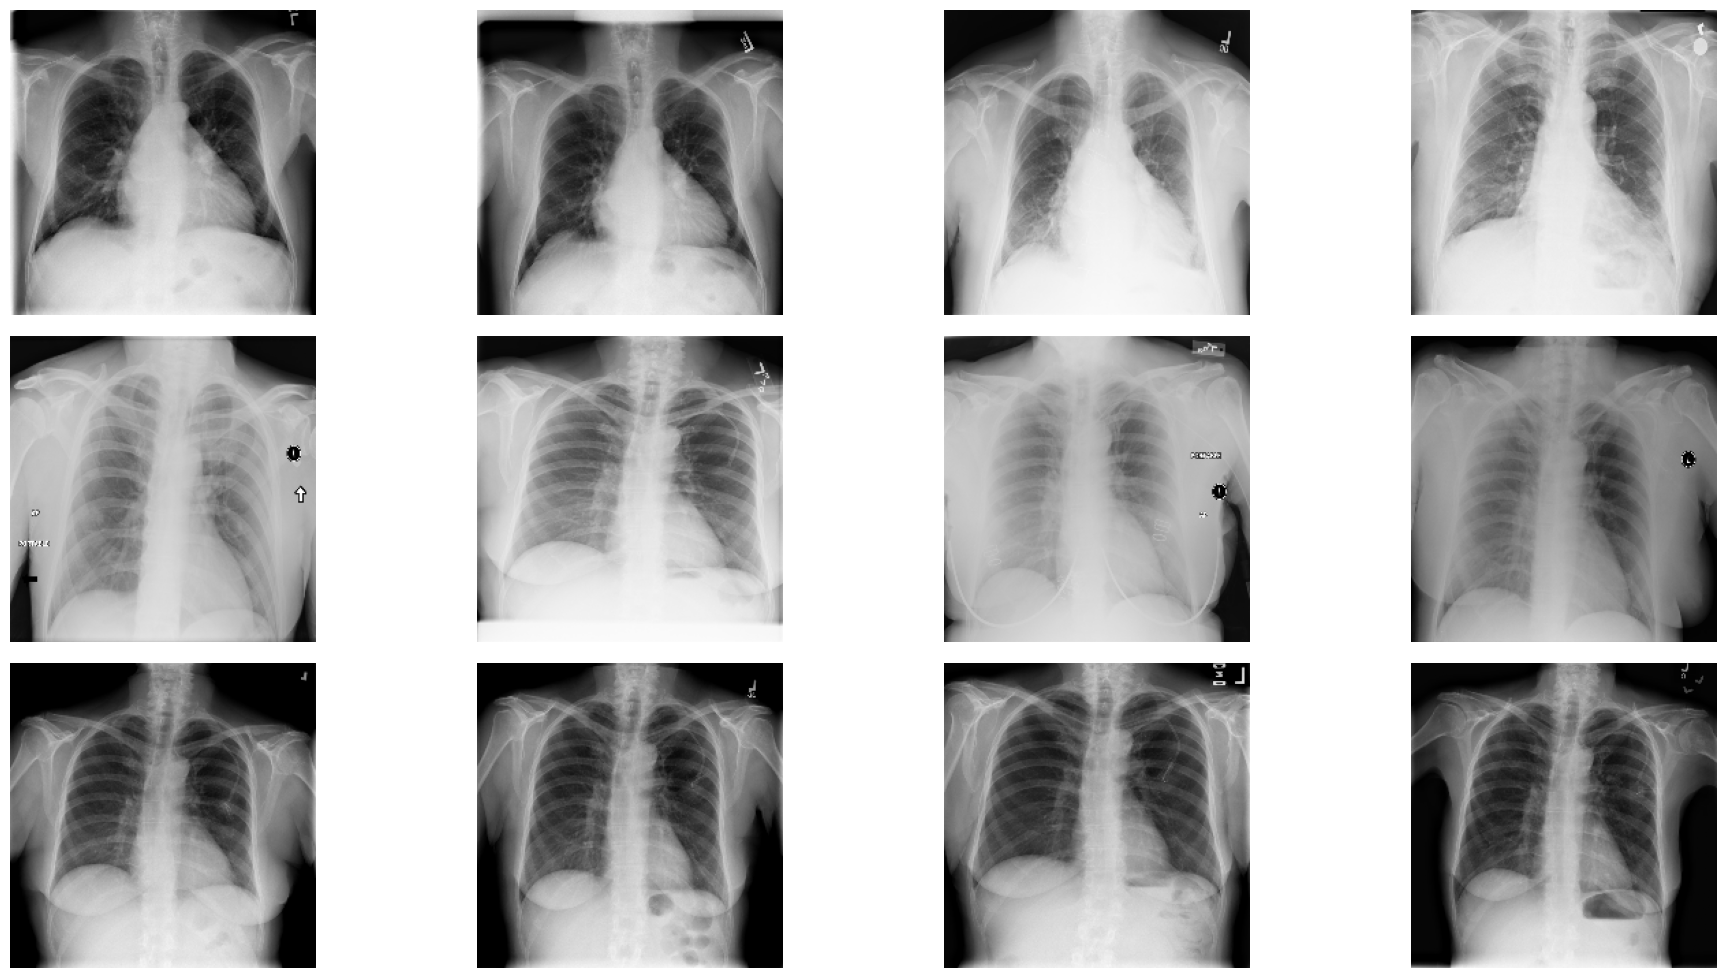

In [115]:
data, _ = train_ds.take(2)
images = data[0].numpy()
labels = data[1].numpy()
print(labels[0])
print(len(labels[0]))

fig, axes = plt.subplots(3, 4, figsize=(20,10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()



In [116]:
MODEL_NAME = "BASE_CSTM_DATA"

weight_path=f"{MODEL_NAME}_weights.best.hdf5"

# https://keras.io/api/callbacks/model_checkpoint/
checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=1, 
    save_best_only=True,
    mode='min',
    save_weights_only = True)

# https://keras.io/api/callbacks/early_stopping/
earlystop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 1e-4,
    patience = 5,
    mode = 'min', 
    restore_best_weights = True,
    verbose = 1)

# https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=1e-4,
    cooldown=1,
    min_lr=1e-6)


callbacks_list = [checkpoint, earlystop, reduceLROnPlat]


Basic_CNN = Sequential([
    # First convolutional layer
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    # Second convolutional layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flattening the results to feed into a dense layer
    Flatten(),

    # Output layer with sigmoid activation for multi-label classification
    Dense(15, activation='sigmoid')
])

weights = {
        0: 1.,
        1: 5.
}

import keras.backend as K

def weighted_cross_entropy_fn(y_true, y_pred):
     tf_y_true = tf.cast(y_true, dtype=y_pred.dtype)
     tf_y_pred = tf.cast(y_pred, dtype=y_pred.dtype)
     weights_v = tf.where(tf.equal(tf_y_true, 1), weights[1], weights[0])
     weights_v = tf.cast(weights_v, dtype=y_pred.dtype)
     ce = K.binary_crossentropy(tf_y_true, tf_y_pred, from_logits=False)
     loss = K.mean(tf.multiply(ce, weights_v))
     return loss
 
def get_weighted_loss():
    def loss(y_true, y_pred):
        return weighted_cross_entropy_fn(y_true, y_pred)
    return loss

Basic_CNN.compile(optimizer='adam', 
                loss=get_weighted_loss(),
                metrics=[
                    keras.metrics.BinaryAccuracy(name='accuracy'),
                    keras.metrics.Precision(name='precision'),
                    keras.metrics.Recall(name='recall'),
                    keras.metrics.AUC(name='auc', multi_label=True)])



In [118]:
# Check if weight checkpoint exists
if os.path.exists(weight_path):
    print("Loading weights from:", weight_path)
    Basic_CNN.load_weights(weight_path)
else:
    print("No weights found, starting training from scratch.")

Loading weights from: BASE_CSTM_DATA_weights.best.hdf5


In [ ]:
# Check if weight checkpoint exists
if os.path.exists(weight_path):
    print("Loading weights from:", weight_path)
    Basic_CNN.load_weights(weight_path)
else:
    print("No weights found, starting training from scratch.")

start = time()
HH = Basic_CNN.fit(
                    train_ds,
                    epochs=5,
                    validation_data=val_ds,
                    # class_weight=dict(enumerate(class_weights)),
                    callbacks=callbacks_list
                    )
print('\nTraining took {} sec'.format((time()-start)))
Basic_CNN.save(f"{MODEL_NAME}.keras")

No weights found, starting training from scratch.
Epoch 1/5


2024-03-24 22:30:04.260861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 565/5408 [==>...........................] - ETA: 2:32 - loss: 0.5403 - accuracy: 0.9224 - precision: 0.5031 - recall: 0.5768 - auc: 0.5364

2024-03-24 22:30:22.401907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


5407/5408 [============================>.] - ETA: 0s - loss: 0.5277 - accuracy: 0.9061 - precision: 0.4397 - recall: 0.6056 - auc: 0.6160
Epoch 1: val_loss improved from inf to 0.68425, saving model to BASE_CSTM_DATA_weights.best.hdf5
5408/5408 [==============================] - 203s 37ms/step - loss: 0.5279 - accuracy: 0.9061 - precision: 0.4396 - recall: 0.6055 - auc: 0.6161 - val_loss: 0.6842 - val_accuracy: 0.8327 - val_precision: 0.2967 - val_recall: 0.5797 - val_auc: 0.5991 - lr: 0.0010
Epoch 2/5
   5/5408 [..............................] - ETA: 2:50 - loss: 0.6459 - accuracy: 0.8542 - precision: 0.3073 - recall: 0.5842 - auc: 0.3678

2024-03-24 22:33:27.126581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 565/5408 [==>...........................] - ETA: 2:34 - loss: 0.5011 - accuracy: 0.9184 - precision: 0.4826 - recall: 0.6204 - auc: 0.6312

2024-03-24 22:33:44.978002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


5408/5408 [==============================] - ETA: 0s - loss: 0.5109 - accuracy: 0.9041 - precision: 0.4337 - recall: 0.6260 - auc: 0.6691
Epoch 2: val_loss improved from 0.68425 to 0.68219, saving model to BASE_CSTM_DATA_weights.best.hdf5
5408/5408 [==============================] - 204s 38ms/step - loss: 0.5109 - accuracy: 0.9041 - precision: 0.4337 - recall: 0.6260 - auc: 0.6691 - val_loss: 0.6822 - val_accuracy: 0.8353 - val_precision: 0.3002 - val_recall: 0.5757 - val_auc: 0.6150 - lr: 0.0010
Epoch 3/5
   5/5408 [..............................] - ETA: 3:01 - loss: 0.6308 - accuracy: 0.8492 - precision: 0.3000 - recall: 0.5941 - auc: 0.3798

2024-03-24 22:36:51.262548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 565/5408 [==>...........................] - ETA: 2:37 - loss: 0.4874 - accuracy: 0.9188 - precision: 0.4850 - recall: 0.6305 - auc: 0.6774

2024-03-24 22:37:09.423590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


5408/5408 [==============================] - ETA: 0s - loss: 0.4937 - accuracy: 0.9057 - precision: 0.4403 - recall: 0.6347 - auc: 0.7178
Epoch 3: val_loss did not improve from 0.68219
5408/5408 [==============================] - 202s 37ms/step - loss: 0.4937 - accuracy: 0.9057 - precision: 0.4403 - recall: 0.6347 - auc: 0.7178 - val_loss: 0.6933 - val_accuracy: 0.8363 - val_precision: 0.2983 - val_recall: 0.5591 - val_auc: 0.6031 - lr: 0.0010
Epoch 4/5
   5/5408 [..............................] - ETA: 3:05 - loss: 0.6373 - accuracy: 0.8650 - precision: 0.3296 - recall: 0.5842 - auc: 0.3704

2024-03-24 22:40:13.052283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 565/5408 [==>...........................] - ETA: 2:35 - loss: 0.4761 - accuracy: 0.9198 - precision: 0.4898 - recall: 0.6308 - auc: 0.7088

2024-03-24 22:40:31.021787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


5407/5408 [============================>.] - ETA: 0s - loss: 0.4728 - accuracy: 0.9062 - precision: 0.4440 - recall: 0.6539 - auc: 0.7622
Epoch 4: val_loss did not improve from 0.68219

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5408/5408 [==============================] - 202s 37ms/step - loss: 0.4729 - accuracy: 0.9062 - precision: 0.4439 - recall: 0.6538 - auc: 0.7623 - val_loss: 0.7138 - val_accuracy: 0.8357 - val_precision: 0.2937 - val_recall: 0.5427 - val_auc: 0.5962 - lr: 0.0010
Epoch 5/5
   5/5408 [..............................] - ETA: 2:52 - loss: 0.6178 - accuracy: 0.8692 - precision: 0.3372 - recall: 0.5743 - auc: 0.4036

2024-03-24 22:43:34.582987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 565/5408 [==>...........................] - ETA: 2:34 - loss: 0.4769 - accuracy: 0.9024 - precision: 0.4231 - recall: 0.6861 - auc: 0.7355

2024-03-24 22:43:52.511286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


5408/5408 [==============================] - ETA: 0s - loss: 0.4593 - accuracy: 0.9074 - precision: 0.4493 - recall: 0.6697 - auc: 0.7824
Epoch 5: val_loss did not improve from 0.68219
5408/5408 [==============================] - 200s 37ms/step - loss: 0.4593 - accuracy: 0.9074 - precision: 0.4493 - recall: 0.6697 - auc: 0.7824 - val_loss: 0.7201 - val_accuracy: 0.8286 - val_precision: 0.2869 - val_recall: 0.5643 - val_auc: 0.6148 - lr: 1.0000e-04

Training took 1010.777037858963 sec


In [ ]:
valR = classification_report(y_val, Basic_CNN.predict(val_ds).round(), target_names=ALL_LABELS)

print(valR)

459/459 [==============================] - 27s 58ms/step
                    precision    recall  f1-score   support

        No Finding       0.46      0.95      0.62      6459
            Hernia       0.00      0.00      0.00        20
         Emphysema       0.07      0.01      0.01       549
            Nodule       0.07      0.04      0.05       925
         Pneumonia       0.02      0.01      0.01       261
     Consolidation       0.12      0.16      0.13       906
      Cardiomegaly       0.10      0.09      0.09       524
          Effusion       0.28      0.58      0.38      2532
              Mass       0.11      0.10      0.11       923
Pleural_Thickening       0.07      0.04      0.05       588
       Atelectasis       0.18      0.42      0.25      1861
      Pneumothorax       0.18      0.06      0.09      1241
          Fibrosis       0.00      0.00      0.00       233
      Infiltration       0.21      0.90      0.35      2992
             Edema       0.11      0.16   

/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



In [119]:
print(classification_report(y_test, Basic_CNN.predict(test_ds).round(), target_names=ALL_LABELS))

2024-03-25 03:01:32.337542: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


15/15 [==============================] - 2s 56ms/step
                    precision    recall  f1-score   support

        No Finding       0.07      1.00      0.13        30
            Hernia       0.00      0.00      0.00        30
         Emphysema       0.00      0.00      0.00        46
            Nodule       0.00      0.00      0.00        57
         Pneumonia       0.00      0.00      0.00        47
     Consolidation       0.20      0.09      0.13        65
      Cardiomegaly       1.00      0.02      0.05        41
          Effusion       0.37      0.57      0.45       129
              Mass       0.67      0.03      0.05        72
Pleural_Thickening       0.00      0.00      0.00        61
       Atelectasis       0.27      0.44      0.34        89
      Pneumothorax       0.00      0.00      0.00        86
          Fibrosis       0.00      0.00      0.00        38
      Infiltration       0.34      1.00      0.51       154
             Edema       0.33      0.02      

/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



15/15 [==============================] - 1s 54ms/step


Text(0, 0.5, 'True Positive Rate')

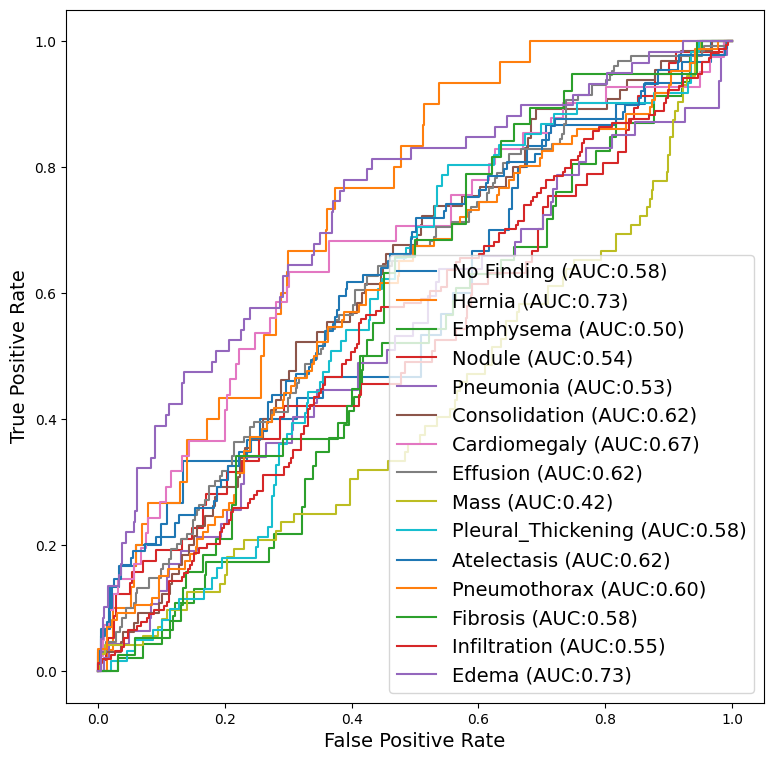

In [122]:
quick_model_predictions = Basic_CNN.predict(test_ds, verbose = 1)

# Credit: Helper function for Plotting - Code sourced directly from Kevin Mader - Simple XRay CNN on 12/09/18
# https://www.kaggle.com/kmader/train-simple-xray-cnn

# import libraries
from sklearn.metrics import roc_curve, auc

# create plot
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (i, label) in enumerate(ALL_LABELS):
    fpr, tpr, thresholds = roc_curve(y_test[:,i].astype(int), quick_model_predictions[:,i])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))

# Set labels for plot
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
# fig.savefig('quick_trained_model.png')

In [123]:
from keras import backend as K
for l in range(len(Basic_CNN.layers)):
    print(l, Basic_CNN.layers[l])

0 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f7abbde5610>
1 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f7b005e51c0>
2 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f7abb3e81c0>
3 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f7abb3e8340>
4 <keras.src.layers.reshaping.flatten.Flatten object at 0x7f7abb3e8280>
5 <keras.src.layers.core.dense.Dense object at 0x7f7abb3e8d30>


In [138]:
# feature extraction layer
feature_extraction_model = Model(inputs=Basic_CNN.inputs, outputs=Basic_CNN.layers[4].output)

X_train.shape, y_train.shape, X_train[0]

((86524,), (86524, 15), 'nih-chest/images_001/images/00000001_000.png')

In [139]:
def parse_and_extract_features(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_png(image_string, channels=CHANNELS)
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_normalized = image_resized / 255.0
    
    # Run the image through the feature extractor
    features = feature_extraction_model(image_normalized[tf.newaxis, ...])  # Add batch dimension
    return features[0], label  # Remove batch dimension for the features

def create_feature_dataset(filenames, labels):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_and_extract_features, num_parallel_calls=NUM_CORES)
    dataset = dataset.batch(16).prefetch(buffer_size=AUTOTUNE)
    return dataset


In [143]:
SUBSET_SIZE = 100
subset_train_filenames = X_train[:SUBSET_SIZE]
subset_train_labels = y_train[:SUBSET_SIZE]

subset_train_ds = create_feature_dataset(subset_train_filenames, subset_train_labels)

In [144]:
feature_tensors = []
labels = []

for features, label in subset_train_ds:
    feature_tensors.append(features.numpy())
    labels.append(label.numpy())

# Concatenate all tensors to form a single numpy array
feature_tensors = np.vstack(feature_tensors)
labels = np.concatenate(labels)

# Make sure labels are reshaped appropriately
# Assuming your labels are one-hot encoded, you'll need to convert them to single labels.
# This step depends on your label format. If labels are already single labels, you can skip this conversion.
labels = np.argmax(labels, axis=1)


2024-03-25 03:36:55.766949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


In [145]:
feature_tensors[0], feature_tensors[0].shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (93312,))

In [127]:
def preprocess_images(image_paths, target_size=(224, 224)):
    """Load and preprocess a list of image paths."""
    images = []
    for path in image_paths:
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, target_size)
        img /= 255.0  # Normalize to [0,1]
        images.append(img)
    return np.stack(images)

base_path = '/home/kayaba_attribution/Documents/UoL/FINAL_PROJECT/Code/'

# Assuming X_train contains paths to the images
image_paths_train = [os.path.join(base_path, img_path) for img_path in X_train]  # Adjust as needed
preprocessed_images_train = preprocess_images(image_paths_train[:100])

2024-03-25 03:02:58.610779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
